## Notebook under construction

#  Use a trained CNN for getting embeddings

The goal of embeddings is to find novel image feature that capture the semantic meaning of the image.

A trained CNN has learned kernels in the convolutional part that transform hierarchically the image in a new feature representation that is called embedding.  In this notebook you will check on the idea that you can use the convolutional part of a trained CNN to generate useful semantic features for an another set of images.  

* You will use a VGG16 that was trained on ImageNet data to extract features form cifar10 images.
* You will visualize the similarities of images of the same class by a t-sne plot based on the pixel features.
* You will visualize the similarities of images of the same class by a t-sne plot based on the VGG16 features.



<a href="https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/embedding.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="open in colab">
</a>
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/embedding.ipynb)



### Loading the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
%matplotlib inline
import numpy as np

import tensorflow as tf
import keras
import sys
print ("Keras {} TF {} Python {}".format(keras.__version__, tf.__version__, sys.version_info))
!date

Using TensorFlow backend.


Keras 2.2.4 TF 1.12.0 Python sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
Tue Dec 11 12:53:43 UTC 2018





### Loading the Cifar10 dataset

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
del [x_test,y_test]

print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


### Sampling only 100 images per class (for computational reasons)

In [3]:
#loop over each class label and sample 100 random images of each label and save the idx to subset
np.random.seed(seed=242)
nr_of_samples_per_class=100
idx=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_train))):
    idx=np.append(idx,np.random.choice(np.where((y_train[0:len(y_train)])==i)[0],nr_of_samples_per_class,replace=False),)

x_train= x_train[idx]
y_train= y_train[idx]
print(x_train.shape)
print(y_train.shape)

(1000, 32, 32, 3)
(1000, 1)


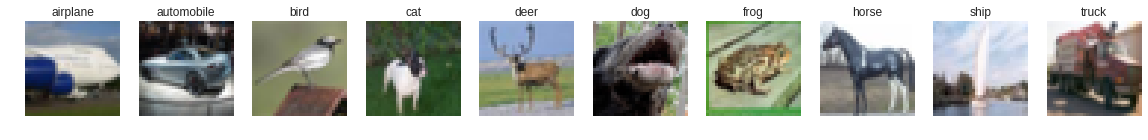

In [4]:
#sample a random image of each label and plot it 
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.axis("off")
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i])





### t-sne on pixel values cifar10


In [0]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=12)
tsne1 = model.fit_transform(x_train.reshape((len(x_train),x_train.shape[1]*x_train.shape[2]*x_train.shape[3])))
#takes some time

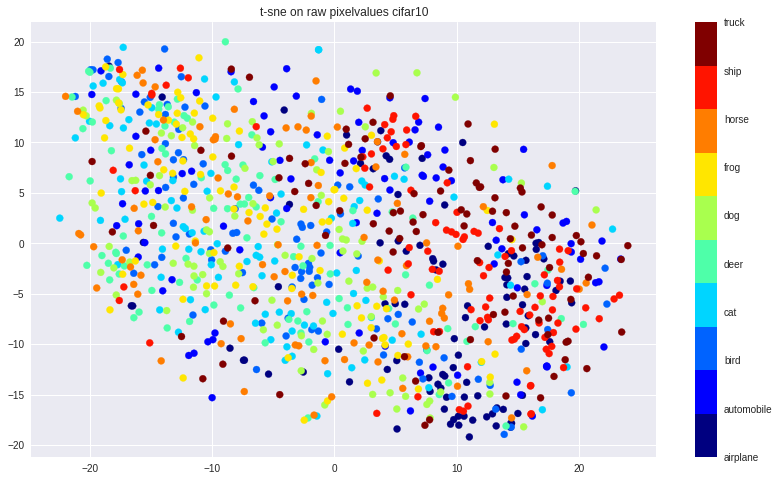

In [6]:
from matplotlib import cm
plt.figure(figsize=(14,8))
cmap = cm.get_cmap('jet', 10)
plt.scatter(x=tsne1[:,0],y=tsne1[:,1],c=y_train.reshape(len(x_train)),cmap=cmap)
plt.title("t-sne on raw pixelvalues cifar10")
cbar = plt.colorbar() 
cbar.ax.set_yticklabels(labels)
plt.show()




** There is almost no structure between the labels when you use the raw image pixels as features for the tsne.  
Let's see if the tsne embedding gets better if we use a pretrained network to extract features. We will use a vgg16 network that was trained on Imagnet. The orginal inputsize of the vgg16 is 224x224x3 pixels, therefore we need to resize our cifar10 images to that size, we will also use the same preprocessing like the vgg team used.
**



/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'resized size (224x224x3)')

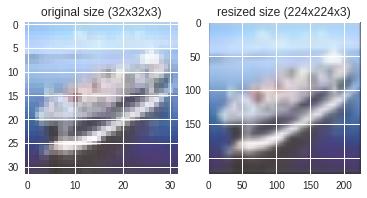

In [7]:
#resizing an image to 224x224x3
from skimage.transform import resize
new_size=224
i=800
img=x_train[i]
img_resized = np.array(resize(img,[new_size,new_size],preserve_range = True),dtype="uint8")
plt.subplot(1,2,(1))
plt.imshow(img)
plt.title("original size (32x32x3)")
#plt.axis("off")
plt.subplot(1,2,(2))
plt.imshow(img_resized)
plt.title("resized size (224x224x3)")
#plt.axis("off")


In [8]:
#resizing all images form x_train to 224x224x3 and apply the preprocessing (subtracting mean from each channel)
from keras.applications.vgg16 import preprocess_input

x_train_resized=np.zeros((len(x_train),new_size,new_size,3))
for i in range(0,len(x_train)):
    img=x_train[i]
    img_resized = np.array(resize(img,[new_size,new_size],preserve_range = True),dtype="uint8")
    img_resized = preprocess_input(img_resized)
    x_train_resized[i]=img_resized

print(x_train_resized.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1000, 224, 224, 3)


### loading the the vgg16 network


In [0]:
new_size=224
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=False,input_shape=(new_size,new_size,3),pooling="avg")

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________


### predicting the  vgg16 features for cifar10



In [0]:
features=model.predict(x_train_resized)

### t-sne on vgg16 features of resized cifar10 images


In [0]:
model = TSNE(n_components=2, random_state=12)
tsne2 = model.fit_transform(features)
#takes some time

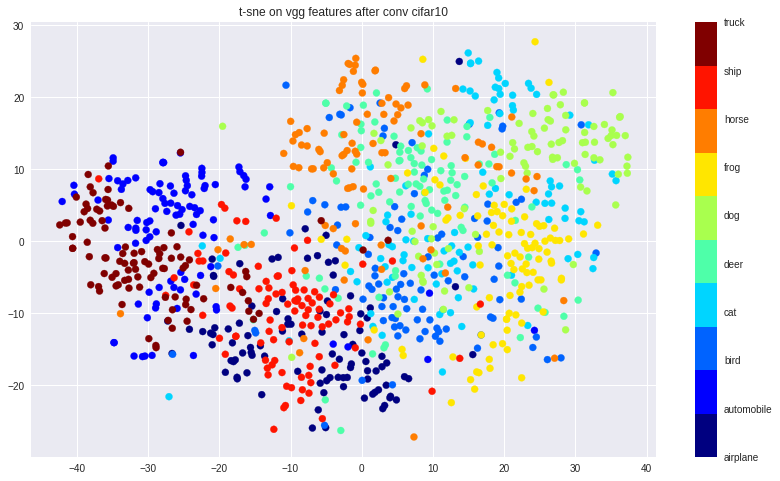

In [13]:
plt.figure(figsize=(14,8))
cmap = cm.get_cmap('jet', 10)
plt.scatter(x=tsne2[:,0],y=tsne2[:,1],c=y_train.reshape(len(x_train)),cmap=cmap)
plt.title("t-sne on vgg features after conv cifar10")
cbar = plt.colorbar() 
cbar.ax.set_yticklabels(labels)
plt.show()




** Now you can see a nice structure beween the labels, similar images are close to each other while diffrent images are further away. So the vgg16 featues that were learned on Imagent are also useful for a diffrent task like in this example for the cifar 10 images.  
Compared to the tsne embedding on the raw pixel data, this embedding is clearly better and has more structure.
**



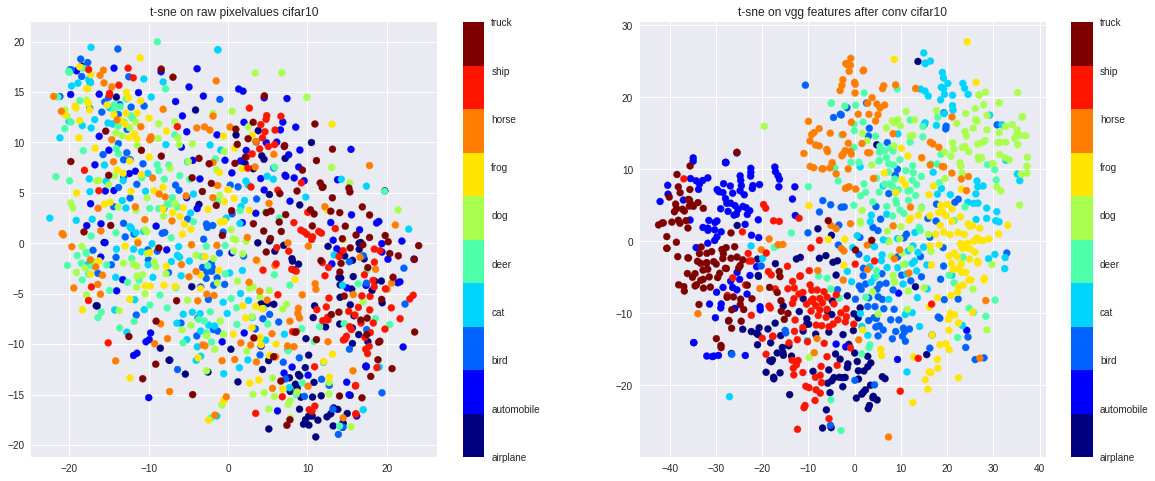

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,(1))
cmap = cm.get_cmap('jet', 10)
plt.scatter(x=tsne1[:,0],y=tsne1[:,1],c=y_train.reshape(len(x_train)),cmap=cmap)
plt.title("t-sne on raw pixelvalues cifar10")
cbar = plt.colorbar() 
cbar.ax.set_yticklabels(labels)
plt.subplot(1,2,(2))
plt.scatter(x=tsne2[:,0],y=tsne2[:,1],c=y_train.reshape(len(x_train)),cmap=cmap)
plt.title("t-sne on vgg features after conv cifar10")
cbar = plt.colorbar() 
cbar.ax.set_yticklabels(labels)
plt.show()